In [1]:
# Azure Data Lake libraries
import azure_data_lake_interface as adl

# Data analysis libraries
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Helper function libraries
from helper_functions import load_config

In [2]:
# attach to the data lake
config = load_config("config/datalake_config.json", flush_cache=True)
service_client = adl.get_azure_service_client(config["blob_url"])
file_system_client = adl.get_azure_file_system_client(service_client, "consolidated")

In [3]:
# get customer and related data
customers = pd.read_csv("data/active_customers.csv")

# change customer_id to string
customers["customer_id"] = customers["customer_id"].astype(str)

In [20]:
sales_orders = adl.get_parquet_file_from_data_lake(file_system_client, "raw/netsuite", "transaction/SalesOrd_raw.parquet")
invoices = adl.get_parquet_file_from_data_lake(file_system_client, "raw/netsuite", "transaction/CustInvc_raw.parquet")

In [21]:
# change net amount to float and created_date to datetime and coerce all dates to datetime
sales_orders["net_amount"] = pd.to_numeric(sales_orders["net_amount"], errors="coerce")
sales_orders["created_date"] = pd.to_datetime(sales_orders["created_date"], errors="coerce")

invoices["net_amount"] = pd.to_numeric(invoices["net_amount"], errors="coerce")
invoices["created_date"] = pd.to_datetime(invoices["created_date"], errors="coerce")

# drop rows with na values in net_amount or created_date
sales_orders = sales_orders.dropna(subset=["net_amount", "created_date"])
invoices = invoices.dropna(subset=["net_amount", "created_date"])

In [22]:
# drop links column
sales_orders.drop(columns="links", inplace=True)
invoices.drop(columns="links", inplace=True)

In [23]:
print(len(sales_orders), len(invoices))

153820 158412


In [24]:
# remove all rows with created_date before Jan 1, 2022
sales_orders = sales_orders[sales_orders["created_date"] >= "2022-01-01"]
invoices = invoices[invoices["created_date"] >= "2022-01-01"]

In [25]:
print(len(sales_orders), len(invoices))

128544 154960


In [26]:
# remove all rows with net_amount less than or equal to 0
sales_orders = sales_orders[sales_orders["net_amount"] >= 0]
invoices = invoices[invoices["net_amount"] >= 0]

In [27]:
print(len(sales_orders), len(invoices))

128544 154960


In [28]:
# join sales orders and then invoices on Customers using customer_id but only use a subset of columns from customers [customer_id, company_name, subsidiary_name, end_market, sales_rep]
augmented_sales_orders = sales_orders.merge(customers[["customer_id", "company_name", "subsidiary_name", "end_market", "sales_rep"]], on="customer_id", how="left")
augmented_invoices = invoices.merge(customers[["customer_id", "company_name", "subsidiary_name", "end_market", "sales_rep"]], on="customer_id", how="left")

In [29]:
# calculate revenue by month by subsidiary
booked_sales_by_subsidiary_by_month = augmented_sales_orders.groupby([augmented_sales_orders["created_date"].dt.to_period("M"), "subsidiary_name"])["net_amount"].sum().reset_index()
# calculate revenue by month by subsidiary
invoiced_sales_by_subsidiary_by_month = augmented_invoices.groupby([augmented_sales_orders["created_date"].dt.to_period("M"), "subsidiary_name"])["net_amount"].sum().reset_index()

In [30]:
booked_sales_by_subsidiary_by_month

,created_date,subsidiary_name,net_amount
0,2022-01,Allied Instrumentation,2915438.98
1,2022-01,Allied Valve,2930361.81
2,2022-01,Automation Service,1670083.42
3,2022-01,Valve Sales Inc.,3291260.83
4,2022-02,Allied Instrumentation,2944489.13
...,...,...,...
135,2024-10,Valve Sales Inc.,7448593.91
136,2024-11,Allied Instrumentation,6257561.90
137,2024-11,Allied Valve,9622793.12
138,2024-11,Automation Service,1286721.18


In [31]:
invoiced_sales_by_subsidiary_by_month

,created_date,subsidiary_name,net_amount
0,2022-01,Allied Instrumentation,1156308.00
1,2022-01,Allied Valve,2409172.99
2,2022-01,Automation Service,1761193.99
3,2022-01,Valve Sales Inc.,1693607.13
4,2022-02,Allied Instrumentation,1541045.59
...,...,...,...
135,2024-10,Valve Sales Inc.,3175460.75
136,2024-11,Allied Instrumentation,5078329.97
137,2024-11,Allied Valve,9470361.38
138,2024-11,Automation Service,1809151.34


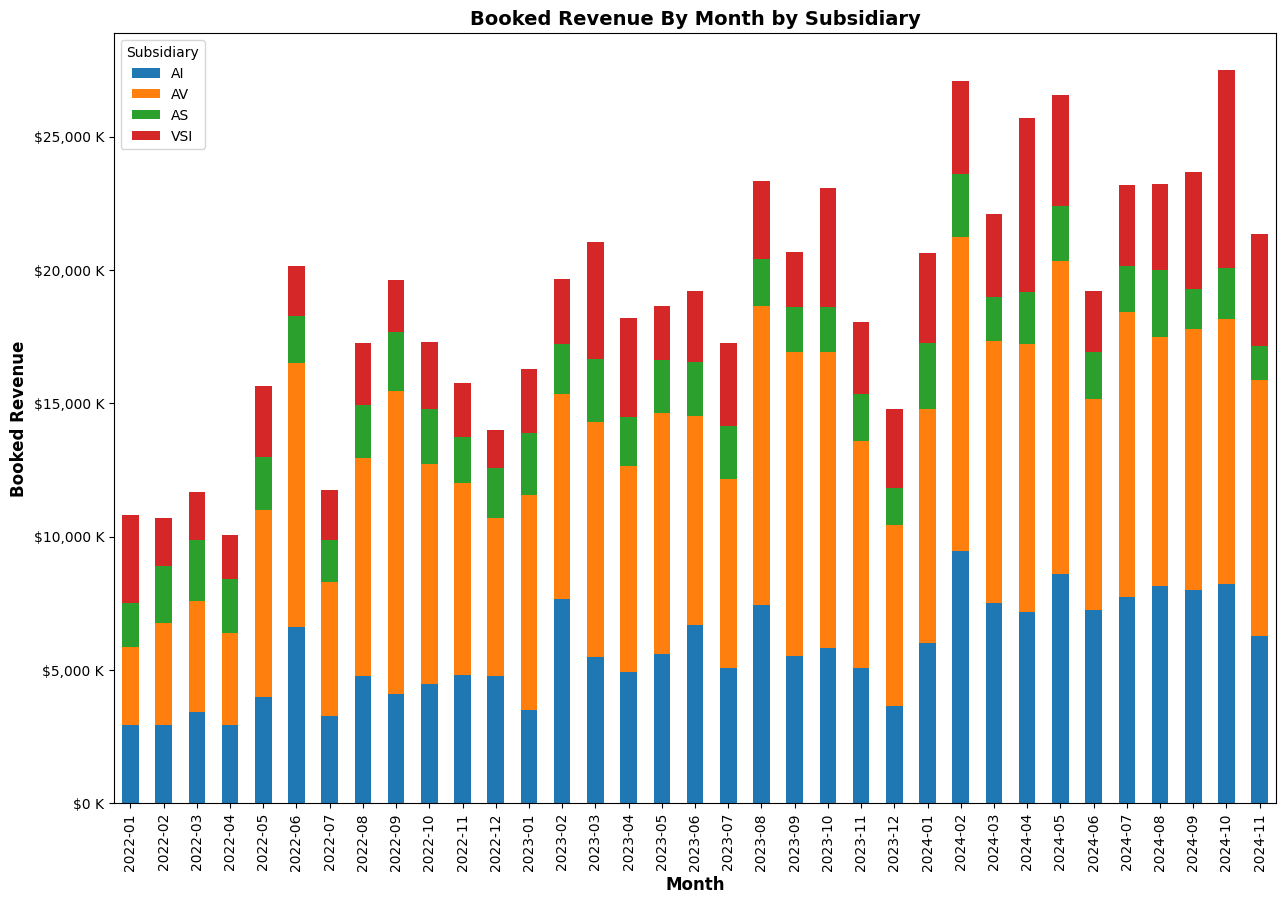

In [32]:
# plot booked sales by month by subsidiary
# Grouping by month and subsidiary
df_grouped = booked_sales_by_subsidiary_by_month.groupby(['created_date', 'subsidiary_name']).sum().unstack('subsidiary_name')

# Plotting
df_grouped.plot(kind='bar', stacked='True', figsize=(15, 10))
plt.title('Booked Revenue By Month by Subsidiary', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Booked Revenue', fontsize=12, fontweight='bold')
plt.legend(title='Subsidiary', labels=['AI', 'AV', 'AS', 'VSI'])

# Custom formatting for y-axis values to show in thousands of dollars
def thousands_formatter(x, pos):
    return f'${x / 1000:,.0f} K'

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show();

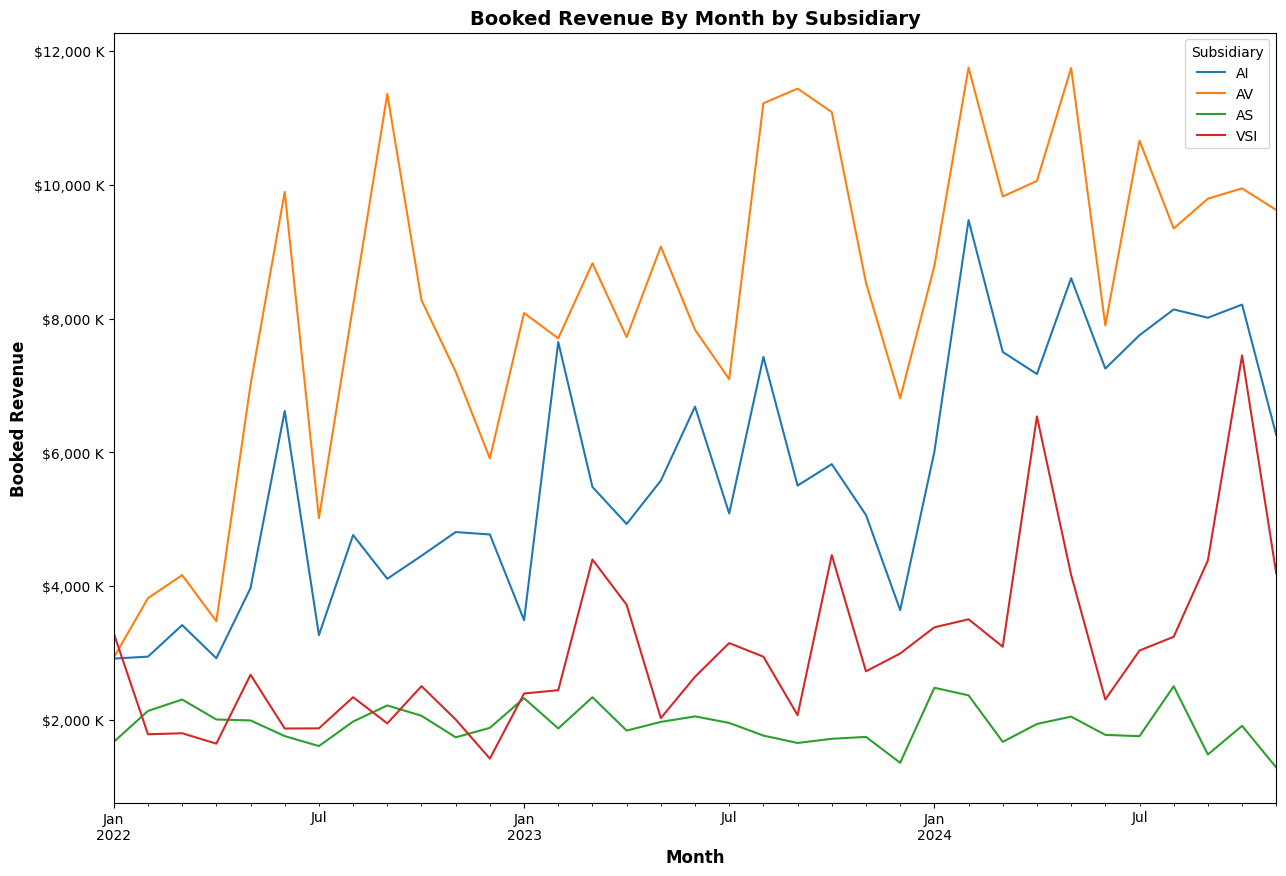

In [33]:
# Plotting
df_grouped.plot(kind='line', figsize=(15, 10))
plt.title('Booked Revenue By Month by Subsidiary', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Booked Revenue', fontsize=12, fontweight='bold')
plt.legend(title='Subsidiary', labels=['AI', 'AV', 'AS', 'VSI'])

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show();

In [ ]:
# plot booked sales by month by subsidiary
# Grouping by month and subsidiary
df_grouped = invoiced_sales_by_subsidiary_by_month.groupby(['created_date', 'subsidiary_name']).sum().unstack('subsidiary_name')

# Plotting
df_grouped.plot(kind='bar', stacked='True', figsize=(15, 10))
plt.title('Invoiced Revenue By Month by Subsidiary', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Invoiced Revenue', fontsize=12, fontweight='bold')
plt.legend(title='Subsidiary', labels=['AI', 'AV', 'AS', 'VSI'])

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show();

In [ ]:
# Plotting
df_grouped.plot(kind='line', figsize=(15, 10))
plt.title('Invoiced Revenue By Month by Subsidiary', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Invoiced Revenue', fontsize=12, fontweight='bold')
plt.legend(title='Subsidiary', labels=['AI', 'AV', 'AS', 'VSI'])

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show();

In [34]:
grouped_df = augmented_sales_orders.groupby([augmented_sales_orders["created_date"].dt.to_period("M"), 'customer_id', 'company_name_y', 'subsidiary_name']).agg(
    booked_revenue=('net_amount', 'sum'),
    num_orders=('id', 'count')
).reset_index()

grouped_df = grouped_df.sort_values(by=['company_name_y', 'created_date']).reset_index(drop=True)

# rename columns created_date, company_name_y
grouped_df.rename(columns={'created_date': 'Month', 'company_name_y': 'company_name'}, inplace=True)

In [35]:
grouped_df

,month,customer_id,company_name,subsidiary_name,booked_revenue,num_orders
0,2024-04,339938,*** Do Not Use*** See customer 55221 Taurus Ga...,Valve Sales Inc.,17232.25,3
1,2024-05,339938,*** Do Not Use*** See customer 55221 Taurus Ga...,Valve Sales Inc.,3319.59,1
2,2024-09,354513,"1 Source Mechanical, Inc.",Allied Valve,3447.81,1
3,2023-08,349277,1301 White River LLC - Forest Creek Ventures -...,Allied Valve,12035.00,2
4,2023-09,349277,1301 White River LLC - Forest Creek Ventures -...,Allied Valve,870.00,1
...,...,...,...,...,...,...
47382,2023-03,287142,"fairlife, LLC",Allied Instrumentation,4088.50,1
47383,2022-07,287830,iTal (International Trading Allian),Automation Service,5065.00,1
47384,2023-11,287830,iTal (International Trading Allian),Automation Service,699.00,1
47385,2024-11,447118,iTec Controls & Electric,Automation Service,30862.00,2


In [36]:
grouped_df = augmented_sales_orders.groupby([augmented_sales_orders["created_date"].dt.to_period("M"), 'end_market', 'subsidiary_name']).agg(
    booked_revenue=('net_amount', 'sum'),
    num_orders=('id', 'count')
).reset_index()

grouped_df = grouped_df.sort_values(by=['end_market', 'created_date']).reset_index(drop=True)

# rename columns created_date, company_name_y
grouped_df.rename(columns={'created_date': 'Month', 'booked_revenue': 'Booked Sales Orders (Net Amount)'}, inplace=True)

In [37]:
grouped_df.to_excel("data/booked_revenue_by_end_market.xlsx", index=False)

In [38]:
grouped_df = augmented_sales_orders.groupby([augmented_sales_orders["created_date"].dt.to_period("M"), 'created_by', 'subsidiary_name']).agg(
    booked_revenue=('net_amount', 'sum'),
    num_orders=('id', 'count')
).reset_index()

grouped_df = grouped_df.sort_values(by=['created_by', 'created_date']).reset_index(drop=True)

# rename columns created_date, company_name_y
grouped_df.rename(columns={'created_date': 'Month', 'booked_revenue': 'Booked Sales Orders (Net Amount)'}, inplace=True)

In [39]:
grouped_df.to_excel("data/booked_revenue_by_creator.xlsx", index=False)